In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

%matplotlib inline

# Import data
df = pd.read_csv("data/data_cummulative.csv");

# Set user groups from enabled features

# Abbreviations:
# - BG: User got no explanations (base group).
# - AE: User got explanations about the routing algorithm (alogorithm explanations).
# - NE: User got explanations depending on the active navigation (navigation explanations).
# - GE: User got both types of explanations (grouped explanations).

df.loc[(df['LowAccuracyCounter'].isna()), 'LowAccuracyCounter'] = 0
df.loc[(df['MaxLowAccuracy'].isna()), 'MaxLowAccuracy'] = 0
df.loc[(df['NumberOfUnnormalRoutes'].isna()), 'NumberOfUnnormalRoutes'] = 0
df.loc[(df['OffRoutePerTenKilometers'].isna()), 'OffRoutePerTenKilometers'] = 0
df.loc[(df['DistanceTraveledInMeters'].isna()), 'DistanceTraveledInMeters'] = 0
df.loc[(df['NumberOfTimesSeenUserCountExplanationShort'].isna()), 'NumberOfTimesSeenUserCountExplanationShort'] = 0
df.loc[(df['NumberOfTimesSeenUserCountExplanationLong'].isna()), 'NumberOfTimesSeenUserCountExplanationLong'] = 0
df.loc[(df['NumberOfTimesSeenCollaborativeRoutingExplanation'].isna()), 'NumberOfTimesSeenCollaborativeRoutingExplanation'] = 0

df["LowAccuracyPerKilometer"] = df["LowAccuracyCounter"] / (df["DistanceTraveledInMeters"] / 1000)
df.loc[(df['LowAccuracyPerKilometer'].isna()), 'LowAccuracyPerKilometer'] = 0

df.loc[(df['GpsQuality'] == False) & (df['TrafficVolume'] == False) & (df['RouteExplanation'] == False) & (df['UserCount'] == False), 'task'] = "BG"
df.loc[(df['GpsQuality'] == False) & (df['TrafficVolume'] == False) & (df['RouteExplanation'] == True) & (df['UserCount'] == True), 'task'] = "AE"
df.loc[(df['GpsQuality'] == True) & (df['TrafficVolume'] == True) & ((df['LowAccuracyCounter'] > 0) | (df['InitialTrafficVolume'] != "Normal")) & (df['RouteExplanation'] == False) & (df['UserCount'] == False), 'task'] = "NE"
df.loc[(df['GpsQuality'] == True) & (df['TrafficVolume'] == True) & ((df['LowAccuracyCounter'] > 0) | (df['InitialTrafficVolume'] != "Normal")) & (df['RouteExplanation'] == True) & (df['UserCount'] == True), 'task'] = "GE"
df.loc[(df['GpsQuality'] == True) & (df['TrafficVolume'] == True) & ((df['LowAccuracyCounter'] <= 0) & (df['InitialTrafficVolume'] == "Normal")) & (df['RouteExplanation'] == False) & (df['UserCount'] == False), 'task'] = "NE"
df.loc[(df['GpsQuality'] == True) & (df['TrafficVolume'] == True) & ((df['LowAccuracyCounter'] <= 0) & (df['InitialTrafficVolume'] == "Normal")) & (df['RouteExplanation'] == True) & (df['UserCount'] == True), 'task'] = "GE"

df.loc[(df['task'] == "BG"), 'group_named'] = "Gruppe 1"
df.loc[(df['task'] == "AE"), 'group_named'] = "Gruppe 2"
df.loc[(df['task'] == "NE"), 'group_named'] = "Gruppe 3"
df.loc[(df['task'] == "GE"), 'group_named'] = "Gruppe 4"

df = df[df['task'].notna()]

# Remove fields with redundant information
df = df.drop(columns=['GpsQuality', 'TrafficVolume', 'RouteExplanation', 'UserCount'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41540 entries, 0 to 41539
Data columns (total 17 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   DeviceId                                          41540 non-null  object 
 1   numberOfRoutes                                    41540 non-null  int64  
 2   InitialTrafficVolume                              41540 non-null  object 
 3   DistanceTraveledInMeters                          41540 non-null  int64  
 4   OffRoutePerTenKilometers                          41540 non-null  float64
 5   LowAccuracyCounter                                41540 non-null  int64  
 6   Rating                                            696 non-null    float64
 7   NumberOfTimesSeenUserCountExplanationShort        41540 non-null  float64
 8   NumberOfTimesSeenUserCountExplanationLong         41540 non-null  float64
 9   NumberOfTimesSeen

In [2]:
# Filter for unusable data
filtered_data = df

filtered_data = filtered_data[filtered_data['Rating'].notna()]
filtered_data = filtered_data[filtered_data['DistanceTraveledInMeters']>5000]

filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625 entries, 78 to 37467
Data columns (total 17 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   DeviceId                                          625 non-null    object 
 1   numberOfRoutes                                    625 non-null    int64  
 2   InitialTrafficVolume                              625 non-null    object 
 3   DistanceTraveledInMeters                          625 non-null    int64  
 4   OffRoutePerTenKilometers                          625 non-null    float64
 5   LowAccuracyCounter                                625 non-null    int64  
 6   Rating                                            625 non-null    float64
 7   NumberOfTimesSeenUserCountExplanationShort        625 non-null    float64
 8   NumberOfTimesSeenUserCountExplanationLong         625 non-null    float64
 9   NumberOfTimesSeenC

In [3]:
g = filtered_data.groupby(['Rating', 'task']).agg(count=('Rating', 'count'))
result = g.reset_index()

result

,Rating,task,count
0,1.0,AE,7
1,1.0,BG,2
2,1.0,GE,4
3,1.0,NE,7
4,2.0,AE,4
5,2.0,BG,6
6,2.0,GE,4
7,2.0,NE,2
8,3.0,AE,2
9,3.0,BG,2


In [4]:
#g = filtered_data.groupby(['DeviceId', 'task']).mean()
#grouped_data_filtered = g.reset_index()

g = filtered_data.groupby(['DeviceId', 'task', 'group_named']).agg(numberOfRoutes=('DeviceId', 'count'))
grouped_data_filtered = g.reset_index()

grouped_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DeviceId        183 non-null    object
 1   task            183 non-null    object
 2   group_named     183 non-null    object
 3   numberOfRoutes  183 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 5.8+ KB


In [5]:
g = filtered_data.groupby('group_named')["DeviceId"].count()
grouped_data_task = g.reset_index()
grouped_data_task.head()

,group_named,DeviceId
0,Gruppe 1,133
1,Gruppe 2,135
2,Gruppe 3,184
3,Gruppe 4,173


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

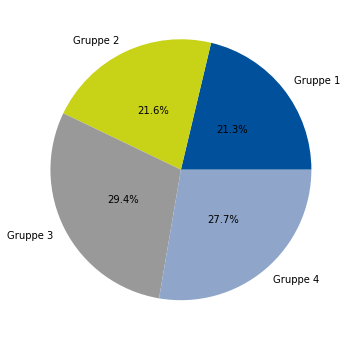

In [6]:
chartColors=["#00509B", "#C8D317", "#999999", "#8FA6CA", "#EE6429", "#E4AF8E"]
labels = grouped_data_task.group_named.sort_values()

pie, ax = plt.subplots(figsize=[10,6])
plt.pie(x=grouped_data_task["DeviceId"], autopct="%.1f%%", labels=labels, pctdistance=0.5, colors=chartColors)
plt

In [7]:
or_data = filtered_data

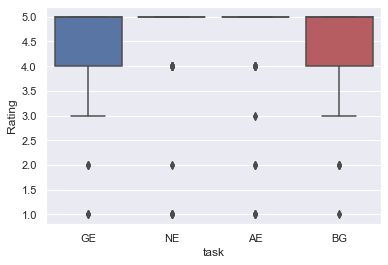

In [8]:
sns.set()
sns.boxplot(data=df, x=or_data.task, y=or_data.Rating)
plt.show()

In [9]:
#Test groups for normality.

experiments = ["BG", "AE", "NE", "GE"]

for e in experiments:
    print("Task ", e, " normality result: ", st.shapiro(or_data[or_data.task==e].Rating))
    print("Variance: ", or_data[or_data.task == e].Rating.var())

Task  BG  normality result:  ShapiroResult(statistic=0.5757380127906799, pvalue=6.01816950383211e-18)
Variance:  0.7343358395989974
Task  AE  normality result:  ShapiroResult(statistic=0.45814597606658936, pvalue=3.1355754534288624e-20)
Variance:  1.0815920398009953
Task  NE  normality result:  ShapiroResult(statistic=0.3524942398071289, pvalue=3.3180071458513357e-25)
Variance:  0.7235685435970538
Task  GE  normality result:  ShapiroResult(statistic=0.52881920337677, pvalue=2.1424092975706707e-21)
Variance:  0.6830219115472509


p < 0.05 -> we can reject the 0-Hypotheses.

Groups are not normally distributed thus we have to take Kruskal Wallis instead of ANONVA

### References

- Glass, G.V., P.D. Peckham, and J.R. Sanders. 1972. Consequences of failure to meet assumptions underlying fixed effects analyses of variance and covariance. Rev. Educ. Res. 42: 237-288.
- Harwell, M.R., E.N. Rubinstein, W.S. Hayes, and C.C. Olds. 1992. Summarizing Monte Carlo results in methodological research: the one- and two-factor fixed effects ANOVA cases. J. Educ. Stat. 17: 315-339.
- Lix, L.M., J.C. Keselman, and H.J. Keselman. 1996. Consequences of assumption violations revisited: A quantitative review of alternatives to the one-way analysis of variance F test. Rev. Educ. Res. 66: 579-619.

In [10]:
import pingouin as pg

res = pg.anova(dv='Rating', between=['task'], data=or_data)

print(res)

  Source  ddof1  ddof2         F     p-unc      np2
0   task      3    621  1.316663  0.267945  0.00632


In [11]:
import pingouin as pg

res = pg.kruskal(data=or_data, dv='Rating', between='task')

print(res)

        Source  ddof1          H    p-unc
Kruskal   task      3  13.695762  0.00335


p < 0.05 --> we can reject the 0-Hypothesis.

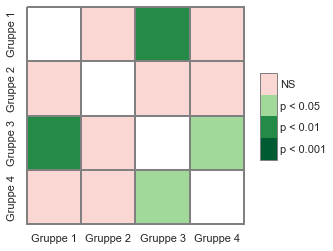

          Gruppe 1  Gruppe 2  Gruppe 3  Gruppe 4
Gruppe 1  1.000000  0.384063  0.005723  1.000000
Gruppe 2  0.384063  1.000000  1.000000  1.000000
Gruppe 3  0.005723  1.000000  1.000000  0.024375
Gruppe 4  1.000000  1.000000  0.024375  1.000000
Mean BG:  4.548872180451128 BG:  5.0  STD:  0.8569339762192869 
Mean AE:  4.5777777777777775 AE:  5.0  STD:  1.0399961729742062 
Mean NE:  4.728260869565218 NE:  5.0  STD:  0.8506283228279281 
Mean GE:  4.601156069364162 GE:  5.0  STD:  0.8264513969661198 


In [12]:
import scipy.stats as st
import scikit_posthocs as sp
from statsmodels.stats.anova import AnovaRM

#pairwise testing:

pc = sp.posthoc_dunn(or_data, val_col="Rating", group_col='group_named', p_adjust="bonferroni")


heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)
plt.savefig('rating_result_significance.pdf')
plt.show()
print(pc)

print("Mean BG: ", or_data[or_data.task == "BG"].Rating.mean(), "BG: ", or_data[or_data.task == "BG"].Rating.median(), " STD: ", or_data[or_data.task == "BG"].Rating.std(),"")
print("Mean AE: ", or_data[or_data.task == "AE"].Rating.mean(), "AE: ", or_data[or_data.task == "AE"].Rating.median(), " STD: ", or_data[or_data.task == "AE"].Rating.std(),"")
print("Mean NE: ", or_data[or_data.task == "NE"].Rating.mean(), "NE: ", or_data[or_data.task == "NE"].Rating.median(), " STD: ", or_data[or_data.task == "NE"].Rating.std(),"")
print("Mean GE: ", or_data[or_data.task == "GE"].Rating.mean(), "GE: ", or_data[or_data.task == "GE"].Rating.median(), " STD: ", or_data[or_data.task == "GE"].Rating.std(),"")
